## Downloading database

In [1]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip /kaggle/input/weatherjena/

## Libraries to use

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

## Preparing data to use

In [4]:
data = pd.read_csv("jena_climate_2009_2016.csv")
# data.shape
# data.head()
data.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


In [5]:
### for univariate LSTM

# extract temperature feature as DataFrame so that shape is as required by LSTM layer (layer, sequence_lenght, feature)
temperature = data[['T (degC)']]
# print(temperature.shape)
temperature.head()

,T (degC)
0,-8.02
1,-8.41
2,-8.51
3,-8.31
4,-8.27


In [6]:
### for multivariate LSTM

features = data.loc[:, ['T (degC)', 'p (mbar)', 'rh (%)', 'H2OC (mmol/mol)', 'rho (g/m**3)']]
# print(features.shape)
features.head()

,T (degC),p (mbar),rh (%),H2OC (mmol/mol),rho (g/m**3)
0,-8.02,996.52,93.3,3.12,1307.75
1,-8.41,996.57,93.4,3.03,1309.80
2,-8.51,996.53,93.9,3.02,1310.24
3,-8.31,996.51,94.2,3.08,1309.19
4,-8.27,996.51,94.1,3.09,1309.00


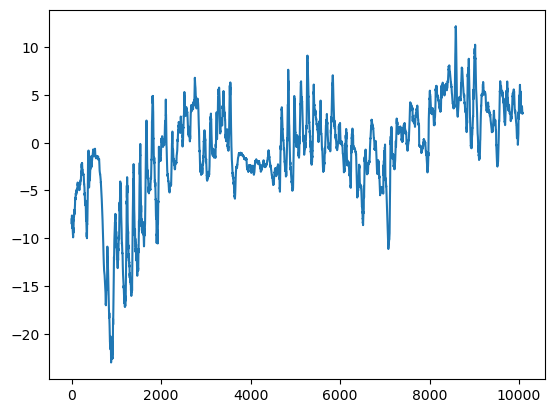

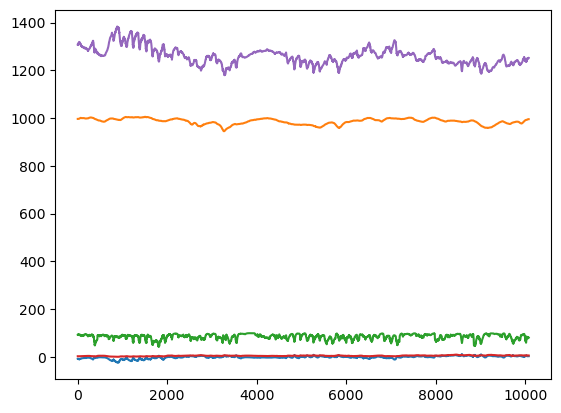

In [7]:
### One week of data plotted (normalised)
plt.plot(range(1440*7), temperature[:1440*7])
plt.show()
plt.plot(range(1440*7), features[:1440*7])
plt.show()

### Definition of Train, Validation and Test datasets

For data segmentation

In [8]:
num_train_samples = len(data)//2
num_val_samples = len(data)//4
num_test_samples = num_val_samples

Univariate timeseries

In [9]:
### normalising data
temperature = (temperature-temperature[:num_train_samples].mean(axis=0))/temperature[:num_train_samples].std(axis=0)
temperature.head()

,T (degC)
0,-1.920636
1,-1.965100
2,-1.976501
3,-1.953699
4,-1.949139


In [10]:
utrain_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data = temperature[:-130],
    targets = temperature[130:],
    sequence_length = 120,
    batch_size = 64,
    start_index = 0,
    end_index = num_train_samples)

In [11]:
uval_dataset = keras.utils.timeseries_dataset_from_array(
    data = temperature[:-130],
    targets = temperature[130:],
    sequence_length = 120,
    batch_size = 64,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

In [12]:
utest_dataset = keras.utils.timeseries_dataset_from_array(
    data = temperature[:-130],
    targets = temperature[130:],
    sequence_length = 120,
    batch_size = 64,
    start_index = num_train_samples + num_val_samples,
    end_index = len(temperature)-130-1)

Multivariate timeseries

In [13]:
### normalising data
features = (features-features[:num_train_samples].mean(axis=0))/features[:num_train_samples].std(axis=0)
features.head()

,T (degC),p (mbar),rh (%),H2OC (mmol/mol),rho (g/m**3)
0,-1.920636,0.913649,1.048015,-1.472032,2.124151
1,-1.965100,0.919528,1.054028,-1.493462,2.172914
2,-1.976501,0.914825,1.084097,-1.495843,2.183381
3,-1.953699,0.912474,1.102138,-1.481556,2.158404
4,-1.949139,0.912474,1.096124,-1.479175,2.153885


In [14]:
mtrain_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data = features[:-130],
    targets = features.iloc[:, [0]],
    sequence_length = 120,
    batch_size = 64,
    start_index = 0,
    end_index = num_train_samples)

In [15]:
mval_dataset = keras.utils.timeseries_dataset_from_array(
    data = features[:-130],
    targets = features.iloc[:, [0]],
    sequence_length = 120,
    batch_size = 64,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

In [16]:
mtest_dataset = keras.utils.timeseries_dataset_from_array(
    data = features[:-130],
    targets = features.iloc[:, [0]],
    sequence_length = 120,
    batch_size = 64,
    start_index = num_train_samples + num_val_samples,
    end_index = len(features)-131)

## Using LSTM layer for the timeseries neural network

In [17]:
lr = 0.001
epochs = 10

In [18]:
##  Piece of code to make sure that the dimensions of the datasets are in the shape that LSTM layer requires
for batch in utrain_dataset.take(1):
    uinputs, utargets = batch

print('Univariate')
print("Input shape:", uinputs.shape, '\nTarget shape:', utargets.shape, '\n')

for batch in mtrain_dataset.take(1):
    minputs, mtargets = batch

print('Multivariate')
print("Input shape:", minputs.shape, '\nTarget shape:', mtargets.shape)

Univariate
Input shape: (64, 120, 1) 
Target shape: (64, 1) 

Multivariate
Input shape: (64, 120, 5) 
Target shape: (64, 1)


In [21]:
model = Sequential()
model.add(LSTM(16, input_shape=(uinputs.shape[1], uinputs.shape[2])))  # (sequence_lenght=120 , features(temperature)=1)
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1152      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
checkpoint = ModelCheckpoint('BestModel.hdf5', monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(utrain_dataset, epochs=epochs, validation_data=uval_dataset, callbacks=[checkpoint])

Epoch 1/10
3283/3283 [==============================] - 88s 26ms/step - loss: 0.1740 - val_loss: 0.1285
Epoch 2/10


/home/dynamix/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3283/3283 [==============================] - 86s 26ms/step - loss: 0.1205 - val_loss: 0.1270
Epoch 3/10
3283/3283 [==============================] - 84s 26ms/step - loss: 0.1138 - val_loss: 0.1200
Epoch 4/10
3283/3283 [==============================] - 85s 26ms/step - loss: 0.1074 - val_loss: 0.1121
Epoch 5/10
3283/3283 [==============================] - 84s 25ms/step - loss: 0.1040 - val_loss: 0.1164
Epoch 6/10
3283/3283 [==============================] - 86s 26ms/step - loss: 0.1021 - val_loss: 0.0997
Epoch 7/10
3283/3283 [==============================] - 87s 26ms/step - loss: 0.1005 - val_loss: 0.1004
Epoch 8/10
3283/3283 [==============================] - 86s 26ms/step - loss: 0.0994 - val_loss: 0.1036
Epoch 9/10
3283/3283 [==============================] - 82s 25ms/step - loss: 0.1027 - val_loss: 0.1148
Epoch 10/10
3283/3283 [==============================] - 84s 26ms/step - loss: 0.1012 - val_loss: 0.1158


In [23]:
model2 = Sequential()
model2.add(LSTM(16, input_shape=(minputs.shape[1], minputs.shape[2])))  # (sequence_lenght=120 , features=4)
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mae')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 16)                1408      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1425 (5.57 KB)
Trainable params: 1425 (5.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
checkpoint2 = ModelCheckpoint('BestModel2.hdf5', monitor='val_loss', save_best_only=True, mode='min')
history2 = model2.fit(mtrain_dataset, epochs=epochs, validation_data=mval_dataset, callbacks=[checkpoint2])

Epoch 1/10
3283/3283 [==============================] - 89s 26ms/step - loss: 0.3587 - val_loss: 0.3342
Epoch 2/10
3283/3283 [==============================] - 86s 26ms/step - loss: 0.3338 - val_loss: 0.3431
Epoch 3/10
3283/3283 [==============================] - 88s 27ms/step - loss: 0.3286 - val_loss: 0.3349
Epoch 4/10
3283/3283 [==============================] - 89s 27ms/step - loss: 0.3258 - val_loss: 0.3390
Epoch 5/10
3283/3283 [==============================] - 86s 26ms/step - loss: 0.3157 - val_loss: 0.3197
Epoch 6/10
3283/3283 [==============================] - 90s 27ms/step - loss: 0.3059 - val_loss: 0.3737
Epoch 7/10
3283/3283 [==============================] - 86s 26ms/step - loss: 0.3177 - val_loss: 0.3712
Epoch 8/10
3283/3283 [==============================] - 86s 26ms/step - loss: 0.3155 - val_loss: 0.3726
Epoch 9/10
3283/3283 [==============================] - 90s 27ms/step - loss: 0.2883 - val_loss: 0.3079
Epoch 10/10
3283/3283 [==============================] - 87s 26m

In [28]:
# model_best_univariate = load_model("BestModel.hdf5")
# # model_best_multivariate = load_model("BestModel2.hdf5")

## Visualizing the learning

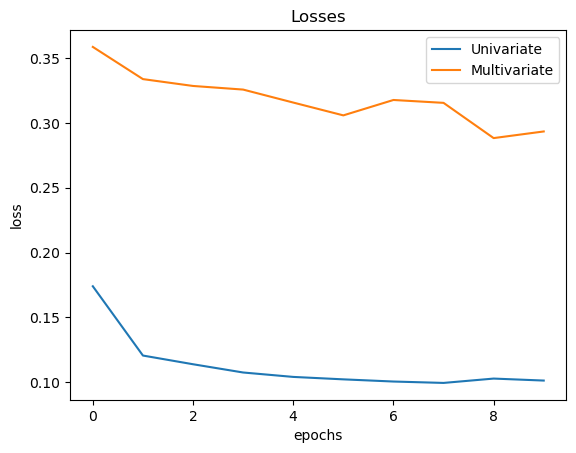

In [25]:
## Here i extract the values of the loss at the end of each epoch to plot it vs  no. of epochs
loss = history.history["loss"]
loss2 = history2.history["loss"]
epoch = range(10)

fig, ax = plt.subplots()
ax.set_title("Losses")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.plot(epoch, loss, label="Univariate")
ax.plot(epoch, loss2, label="Multivariate")
ax.legend()
plt.show()

## Predicting temperature using only past temperatures

In [26]:
for batch in utest_dataset.take(1):
    upast, ufuture = batch
    
print("Input shape:", upast.shape, '\nTarget shape:', ufuture.shape, '\n')

Input shape: (64, 120, 1) 
Target shape: (64, 1) 



In [27]:
predicted = model.predict(upast)
print(len(predicted))

2/2 [==============================] - 0s 14ms/step
64


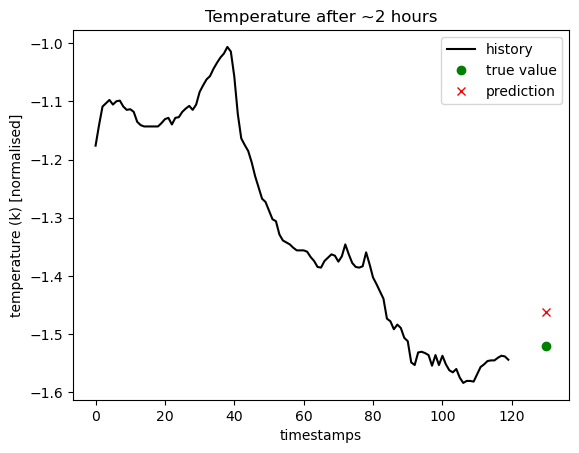

In [28]:
n = 0
h_timpestamps = range(len(upast[n]))

fig, ax = plt.subplots()
ax.set_title("Temperature after ~2 hours")
ax.set_xlabel("timestamps")
ax.set_ylabel("temperature (k) [normalised]")
ax.plot(h_timpestamps, upast[n], label="history", color="k")
ax.plot(130, ufuture[n], "og", label="true value")
ax.plot(130, predicted[n], "xr", label="prediction")
ax.legend()
plt.show()

## Predictions of temperature using other parameters

In [29]:
for batch in mtest_dataset:
    mpast, mfuture = batch

print("Input shape:", mpast.shape, '\nTarget shape:', mfuture.shape, '\n')

Input shape: (32, 120, 5) 
Target shape: (32, 1) 



In [30]:
predicted2 = model2.predict(mpast)
print(len(predicted2))

1/1 [==============================] - 0s 323ms/step
32


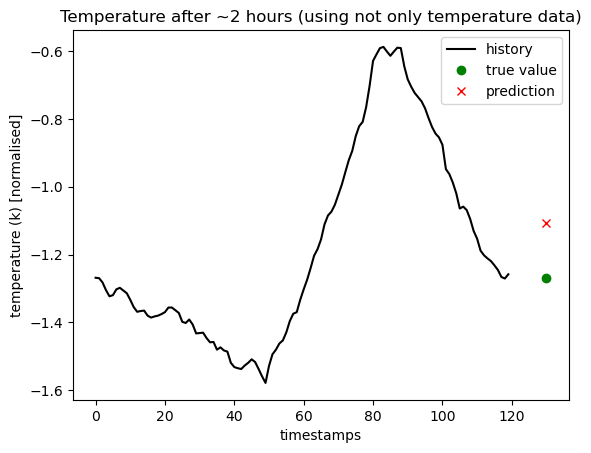

In [31]:
n = 0
h_timpestamps = range(len(mpast[n]))

fig, ax = plt.subplots()
ax.set_title("Temperature after ~2 hours (using not only temperature data)")
ax.set_xlabel("timestamps")
ax.set_ylabel("temperature (k) [normalised]")
ax.plot(h_timpestamps, mpast[n, :, 0], label="history", color="k")
ax.plot(130, mfuture[n], "og", label="true value")
ax.plot(130, predicted2[n], "xr", label="prediction")
ax.legend()
plt.show()